In [1]:
# !pip install pyMCFSimplex 
# !pip install gurobipy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import time
from datetime import datetime
from time import process_time
from scipy.optimize import *
from scipy.optimize import minimize_scalar
import gurobipy as gp
from gurobipy import GRB
from pyMCFSimplex import *

### 1. Generazione delle istanze del problema
La prima funzione *genera_Q(alpha, u, q, dimensione, p)* serve per generare i costi quadratici 
che si aggiungono ai costi lineari dell'istanza di MCF;
la stategia di generazione prevede di generare randomicamente (uniformemente) costi Qij "piccoli" o "grandi" rispetto ai costi lineari, 
come specificato dal parametro *alpha*. 

Permette inoltre di definire - tramite il parametro *p* - la proporzione di archi che hanno costo quadratico Qij nullo, 
abilitando la definizione e l'analisi anche di matrici semi-definite positive (0 &le; p &le; 1). 

La seconda funzione *leggi_file_dimacs(nome_file)* serve per estrarre le seguenti quantità: 
 - u, b, q
 - numero nodi
 - numero archi 

dal relativo file *.dmx*, generato [qui](https://commalab.di.unipi.it/datasets/mcf/). 

In [3]:
def genera_Q(alpha, u, q, dimensione, p):
    
    Q_diag = []

    for i in range(dimensione):
        Q_i = abs(random.uniform((-q[i] / u[i] * alpha), (q[i] / u[i] * alpha))) # generazione randomica 
        Q_diag.append(Q_i)

    Q = np.zeros((dimensione, dimensione))
    np.fill_diagonal(Q, Q_diag) # creazione matrice 

    num_entrate_zero = int(p * dimensione) 
    indici_zeri = np.random.choice(dimensione, num_entrate_zero, replace=False) # trova p*dimensione indici dei costi quadratici da mettere a zero 

    for idx in indici_zeri:
        Q[idx, idx] = 0
        # Q_diag[idx] = 0

    return Q #, Q_diag


def leggi_file_dimacs(nome_file):
    numero_nodi = 0
    numero_archi = 0
    u = []
    b = []
    q = []
    from_= []
    to_= []
    edges = []

    with open(nome_file, 'r') as file:
        for line in file:
            parts = line.split()
            if len(parts) > 0:
                if parts[0] == 'p':  # parts[0] è il primo carattere di ogni riga - nel formato standard DIMACS può essere c, p, n, a
                    # legge il numero di nodi e archi dal problema
                    numero_nodi = int(parts[2])
                    numero_archi = int(parts[3])
                    # inizializza il vettore di supply con zeri
                    b = [0] * numero_nodi
                elif parts[0] == 'n':
                    # legge i valori di supply per i nodi
                    nodo_id = int(parts[1])
                    supply = int(parts[2])
                    # assegna il valore di supply al nodo corrispondente
                    b[nodo_id - 1] = supply
                elif parts[0] == 'a':
                    # leggi l'arco e il suo cotso
                    from_node = int(parts[1])
                    to_node = int(parts[2])
                    max_capacity = int(parts[4])
                    costo = int(parts[5]) 
                    from_.append(from_node)
                    to_.append(to_node)
                    u.append(max_capacity)
                    q.append(costo)
                    edges.append((from_node , to_node ))

    return numero_nodi, numero_archi, np.array(u), b, np.array(q), edges,from_, to_

### 2. Implementazione dell'algoritmo

In [4]:
# MCF solver intern - do not change
def showModuleFunctionality(mcf):
    vettore_soluzione = {}  
    nmx = mcf.MCFnmax()
    mmx = mcf.MCFmmax()
    pn = mcf.MCFnmax()
    pm = mcf.MCFmmax()

    pU = []
    caps = new_darray(mmx)
    mcf.MCFUCaps(caps)
    for i in range(0, mmx):
        pU.append(darray_get(caps, i))

    pC = []
    costs = new_darray(mmx)
    mcf.MCFCosts(costs)
    for i in range(0, mmx):
        pC.append(darray_get(costs, i))

    pDfct = []
    supply = new_darray(nmx)
    mcf.MCFDfcts(supply)
    for i in range(0, nmx):
        pDfct.append(darray_get(supply, i))

    pSn = []
    pEn = []
    startNodes = new_uiarray(mmx)
    endNodes = new_uiarray(mmx)
    mcf.MCFArcs(startNodes, endNodes)
    for i in range(0, mmx):
        pSn.append(uiarray_get(startNodes, i) + 1)
        pEn.append(uiarray_get(endNodes, i) + 1)

    #print("arc flow")
    length = mcf.MCFm()
    flow = new_darray(length)
    length = mcf.MCFn()
    nms = new_uiarray(length)
    mcf.MCFGetX(flow, nms)

   

    for i in range(0, length):
        if uiarray_get(nms, i)== 4294967295:
            break
        else:
       # print("flow", darray_get(flow, i), "arc", uiarray_get(nms, i))
            vettore_soluzione[uiarray_get(nms, i)] = darray_get(flow, i)

    return vettore_soluzione  # restituisce il vettore_soluzione alla fine della funzione

In [5]:
def visualize(k, f_val, alpha, prodotto_scalare, k_granularity, tempo, end, found_optimal): 

    # la funzione stampa un summary delle seguenti quantità ad ogni iterazione (oppure ogni 'k_granularity' iterazioni) :
    # - iterazione corrente
    # - step size, 
    # - optimal solution, 
    # - prodotto scalare 

    # alla fine dell'esecuzione verrà mostrato :
    # - prodotto scalare finale,
    # - step size finale
    # - numero totale di iterazioni
    # - tempo di esecuzione totale 
    
    if end:
        print("_"*110)
        print("STOP: ")
        if found_optimal:
            print('Found optimal solution!')
        print('Final scalar product: {:>10.6f}  Final step size: {:>10.8f}  Total number iterations: {:>4}'.format(prodotto_scalare, alpha, k))
        print('Total running time: {:>10.2f} seconds'.format(tempo))    
        
    if  k % k_granularity == 0:
        print('Iteration: {:>4}   Step size: {:>10.8f}   Valore di f in x_k: {:>10.6f}   Scalar product grad, d: {:>10.2f} '.format(k, alpha, f_val, prodotto_scalare))
    return

In [6]:
class ProblemUnfeasibleError(Exception):
    pass

In [7]:
def modify_dimacs(input_file_path, output_file_path, new_min, new_max, gradient):
    
    """
    Create a new DIMACS file with modified minflow values and gradients.

    Parameters:
    - input_file_path: Path to the original DIMACS file.
    - output_file_path: Path to the new DIMACS file with modified minflow values and gradients.
    - new_min: NumPy array containing the new minflow values for the arc descriptor lines.
    - gradient: NumPy array containing the gradient values for the arc descriptor lines.
    """
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

    # Find the arc descriptor lines and update the minflow values, maxflow values, and gradients
    arc_lines = [line for line in lines if line.startswith('a ')]
    for i, line in enumerate(arc_lines):
        components = line.split()
        if len(components) == 6 and i < len(new_min):
            components[3] = str(new_min[i])
            components[4] = str(new_max[i])  
            components[-1] = str(gradient[i])
            arc_lines[i] = ' '.join(components) + '\n'


    # Combine original lines and modified arc lines
    modified_lines = lines.copy()
    for i, line in enumerate(modified_lines):
        if line.startswith('a '):
            modified_lines[i] = arc_lines.pop(0)

    with open(output_file_path, 'w') as new_file:
        new_file.writelines(modified_lines)


In [35]:
def FW_trad_modificato(b,n,from_,to,f_tol, time_tol, epsilon, Q, q, u, tau, max_iter, numero_archi, x, step_size_ottimo=True, visualize_res=True):
    k = 0
    now = datetime.now()
    dual_gap = []
    function_value = [func(x)]
    elapsed_time = [0]  
    tempo_per_it_MCF = [0]  
    f_improv = np.inf
    tempi_per_it = [0]
    status = 'processing'
    bestlb = float('-inf')
    lb_trust = np.zeros(numero_archi)
    ub_trust = np.array(u)
    alpha = 1
    
    while abs(f_improv) > f_tol and elapsed_time[-1] < time_tol:
    #while elapsed_time[-1] < time_tol:
        start = time.perf_counter()

        gradient = (2 * np.dot(Q, x)) + q

        #### TRUST REGION STABILIZATION ####

        if tau > 0 and k > 1:
            # calcolo lower bound e upper bound della trust region 
            lb_trust = np.maximum(0, x - tau * u) 
            ub_trust = np.minimum(u, x + tau * u)
        modify_dimacs('1000/netgen-1000-1-1-b-b-s.dmx', 'prova.dmx', lb_trust.astype(int), ub_trust.astype(int), gradient)

        ###################################

        FILENAME = 'prova.dmx'
        f = open(FILENAME,'r')
        inputStr = f.read()
        f.close()
        
        start_MCF = time.perf_counter()
        mcf = MCFSimplex()
        mcf.LoadDMX(inputStr)
        mcf.SolveMCF()
      
        end_MCF = time.perf_counter()  
        tempo_per_it_MCF.append(end_MCF - start_MCF)  

        if mcf.MCFGetStatus() != 0:
            raise ProblemUnfeasibleError("The problem is unfeasible!")

        vettore_soluzione = showModuleFunctionality(mcf)
        sol_x = [0] * numero_archi

        for key in vettore_soluzione:
            sol_x[key] = vettore_soluzione[key]

        v = np.array(sol_x)
        d = v - x

        if visualize_res and k > 0:
            print(f'iter: {k}, fval = {function_value[-1]}, fbest = {func(x):.8e}, gap = {dual_gap[-1]:.4e}')


        lb = func(x)+ np.dot(np.array(gradient), np.array(v) - np.array(x))  
        if lb > bestlb:
            bestlb = lb
        gap = (func(x) - bestlb) / max(abs(func(x)), 1)  # relative gap

        dual_gap.append(gap)

        if abs(gap) <= epsilon:  
            status = 'found optimal'
            break
        
        if k == max_iter:
            status = 'stopped (max_iter)'
            print(status)
            break
        

        if step_size_ottimo:
            x, alpha = line_search(x, d, 1, func)
        else:
            alpha = 2 / (2 + k)
            x = x + alpha * d

        end = time.perf_counter()
        tempo_it = end - start
        tempi_per_it.append(tempo_it)
        elapsed_time.append(elapsed_time[k] + tempo_it) 
        
        f_improv = function_value[-1] - func(x)
        function_value.append(func(x))
        
        k += 1

        if abs(f_improv) < f_tol:
            status = 'stopped (f_tol)'
            print(status)
            break
        if elapsed_time[-1] > time_tol:
            status = 'stopped (time_tol)'
            print(status)
            break

    print('Status:', status)
    print()
    print('Final gap duale: {:>10.6f}  Final step size: {:>10.8f}  Total number iterations: {:>4}'.format(dual_gap[-1], alpha, k))
    print('fbest:', func(x))
    print('Total running time: ', sum(tempi_per_it))

    return x, function_value, elapsed_time, dual_gap, k, tempi_per_it, tempo_per_it_MCF, status


In [7]:
def FW_trad_modificato_notrust(b,n,from_,to,f_tol, time_tol, epsilon, Q, q, u, tau, max_iter, numero_archi, x, step_size_ottimo=True, visualize_res=True):
    k = 0
    now = datetime.now()
    dual_gap = []
    function_value = [func(x)]
    elapsed_time = [0]  
    tempo_per_it_MCF = [0]  
    f_improv = np.inf
    tempi_per_it = [0]
    status = 'processing'
    bestlb = float('-inf')

    while abs(f_improv) > f_tol and elapsed_time[-1] < time_tol:
    #while elapsed_time[-1] < time_tol:
        start = time.perf_counter()

        gradient = (2 * np.dot(Q, x)) + q

        mcf = MCFSimplex()
        start_MCF = time.perf_counter()  
        nmx = n 
        mmx = numero_archi
        pn = n 
        pm = numero_archi
        pU = u.tolist()
        pC  = gradient.tolist()
        pDfct = b 
        pSn = to 
        pEn = from_

        ### TRUST REGION STABILIZATION ###
        if tau > 0: 
            lb = x - tau * u # calcolo lower bound e upper bound della trust region 
            ub = x + tau * u
            pU = ub.tolist()

        mcf.LoadNet(nmx, mmx, pn, pm, CreateDoubleArrayFromList(pU), CreateDoubleArrayFromList(pC),
            CreateDoubleArrayFromList(pDfct), CreateUIntArrayFromList(pSn),
            CreateUIntArrayFromList(pEn))
        
        mcf.SolveMCF()
      
        end_MCF = time.perf_counter()  
        tempo_per_it_MCF.append(end_MCF - start_MCF)  

        if mcf.MCFGetStatus() != 0:
            raise ProblemUnfeasibleError("The problem is unfeasible!")

        vettore_soluzione = showModuleFunctionality(mcf)
        sol_x = [0] * numero_archi

        for key in vettore_soluzione:
            sol_x[key] = vettore_soluzione[key]

        v = np.array(sol_x)
        u = np.array(u)
        d = v - x

        if visualize_res and k > 0:
            print(f'iter: {k} iter, fval = {f_values[-1]}, fbest = {func(x):.8e}, gap = {dual_gap[-1]:.4e}')


        lb = func(x)+ np.dot(np.array(gradient), np.array(v) - np.array(x))  
        if lb > bestlb:
            bestlb = lb
        gap = (func(x) - bestlb) / max(abs(func(x)), 1)  # relative gap

        dual_gap.append(gap)
        print('gap', gap)
        if gap <= epsilon:  
            status = 'found optimal'
            break
        
        if k == max_iter:
            status = 'stopped (max_iter)'
            print(status)
            break
        

        if step_size_ottimo:
            x, alpha = line_search_afw(x, d, 1, func)
        else:
            alpha = 2 / (2 + k)
            x = x + alpha * d

        end = time.perf_counter()
        tempo_it = end - start
        tempi_per_it.append(tempo_it)
        elapsed_time.append(elapsed_time[k] + tempo_it) 
        
        f_improv = function_value[-1] - func(x)
        function_value.append(func(x))
        
        k += 1

        if abs(f_improv) < f_tol:
            status = 'stopped (f_tol)'
            print(status)
            break
        if elapsed_time[-1] > time_tol:
            status = 'stopped (time_tol)'
            print(status)
            break


        print('Status:', status)
        print()
        print('Final gap duale: {:>10.6f}  Final step size: {:>10.8f}  Total number iterations: {:>4}'.format(dual_gap[-1], alpha, k))
        print('Total running time: ', sum(tempi_per_it))

    return x, function_value, elapsed_time, dual_gap, k, tempi_per_it, tempo_per_it_MCF, status

#### 2b. Algoritmo FW variante - AWAY STEP

In [10]:
# away vertex
def away_step(grad, S):
    costs = {}
    
    for k,v in S.items():
        cost = np.dot(k,grad)
        costs[cost] = [k,v]
    vertex, alpha = costs[max(costs.keys())]  
    return vertex, alpha

# aggiornare active set come pseudocodice 
def update_S(S,gamma, Away, vertex):
    
    S = S.copy()
    vertex = tuple(vertex)
    
    if not Away:
        if vertex not in S.keys():
            S[vertex] = gamma
        else:
            S[vertex] *= (1-gamma)
            S[vertex] += gamma
            
        for k in S.keys():
            if k != vertex:
                S[k] *= (1-gamma)
    else:
        for k in S.keys():
            if k != vertex:
                S[k] *= (1+gamma)
            else:
                S[k] *= (1+gamma)
                S[k] -= gamma
    return {k:v for k,v in S.items() if np.round(v,3) > 0}


In [11]:
def visualize_bis(k, f_val, alpha, primal_gap_k, k_granularity): 

    # la funzione stampa un summary delle seguenti quantità ad ogni iterazione (oppure ogni 'k_granularity' iterazioni) :
    # - iterazione corrente
    # - step size, 
    # - optimal solution, 
    # - prodotto scalare 

    # alla fine dell'esecuzione verrà mostrato :
    # - prodotto scalare finale,
    # - step size finale
    # - numero totale di iterazioni
    # - tempo di esecuzione totale 
    
     if  k % k_granularity == 0:
        print('Iteration: {:>4}   Step size: {:>10.8f}   Valore di f in x_k: {:>10.6f}   Dual gap: {:>10.2f} '.format(k, alpha, f_val, primal_gap_k))
        return

In [12]:
def line_search(x, d, gamma_max,func):
    
    def fun(gamma):
        ls = x + gamma*d
        return func(ls)

    res = minimize_scalar(fun, bounds=(0, gamma_max), method='bounded')

    gamma = res.x
    ls = x + gamma*d        
    return ls, gamma

In [47]:
# AFW 
 
def AFW(epsilon, max_iter, Q, q, numero_archi,func, k_granularity, x, visualize_res=True):
    
    k = 0    
    bestlb = -np.inf
    gamma = 1
    start_time = time.time()
    tempo_tot = 0
    status = 'processing'
    f_values = []
    tempi_per_it = [0]
    gap = []
    now = datetime.now()
    dual_gap = []
    elapsed_time = [0]  
    tempo_per_it_MCF = [0]  
    f_improv = np.inf
    tempi_per_it = [0]  
  
    S = {tuple(np.array(x)): 1} # active set inizializzazione
   

    while abs(f_improv) > f_tol and elapsed_time[-1] < time_tol:
   # while abs(prodotto_scalare)>= epsilon and k < max_iter: # stopping criteria

        start = time.perf_counter()

        f_values.append(func(x))

        # STEP 1 : calcolo gradiente
        gradient = (2 * np.dot(Q, x)) + q

        mcf = MCFSimplex()
        start_MCF = time.perf_counter()  
        nmx     = n
        mmx     = numero_archi
        pn      = n
        pm      = numero_archi
        pU      = u.tolist()
        pC      = gradient.tolist()
        pDfct   = b
        pSn     = to
        pEn     = from_
     
        mcf.LoadNet(nmx, mmx, pn, pm, CreateDoubleArrayFromList(pU), CreateDoubleArrayFromList(pC),
            CreateDoubleArrayFromList(pDfct), CreateUIntArrayFromList(pSn),
            CreateUIntArrayFromList(pEn))
        
        mcf.SolveMCF()

        end_MCF = time.perf_counter() 
        tempo_per_it_MCF.append(end_MCF - start_MCF)  

        if mcf.MCFGetStatus() != 0:
            raise ProblemUnfeasibleError("The problem is unfeasible!")

        vettore_soluzione = showModuleFunctionality(mcf)
        sol_x = [0] * numero_archi

        for key in vettore_soluzione:
            sol_x[key] = vettore_soluzione[key]

        # calcolo delle x_bar e determinazione della direzione di ricerca
        v = sol_x.copy()
        d_FW = v - x
        
        # calcolo away vertex e direzione d_A 
        a, alpha_a = away_step(gradient, S)
        d_A = x - a
       
        # check se FW gap è maggiore dell'away gap --> per capire quale passo usare 
        if np.dot(-gradient, d_FW) >= np.dot(-gradient, d_A):
            # scegliamo FW direction
            d = d_FW
            vertex = v
            gamma_max = 1
            Away = False
        else:
            # scegliamo Away direction
            d = d_A
            vertex = a
            gamma_max = alpha_a/(1-alpha_a)

        if visualize_res and k > 0:
            #visualize_bis(k, function_value[-1], alpha, primal_gap[-1], k_granularity=1)
            print(f'iter: {k} iter, fval = {f_values[-1]}, fbest = {func(x):.8e}, gap = {dual_gap[-1]:.4e}')
        
        lb = func(x)+ np.dot(np.array(gradient), np.array(d))  # Compute the lower bound
       
        if lb > bestlb:
            bestlb = lb
        
        gap = (func(x) - bestlb)/ max(abs(func(x)), 1)  # relative gap
        dual_gap.append(gap)
        
        if gap <= epsilon:  
            status = 'found optimal'
            print(status)
            break
        if k == max_iter:
            status = 'stopped (max_iter)'
            print(status)
            break

        # ricerca di x_new e gamma usando line search 
        x, gamma = line_search(x,d, gamma_max, func)

        # aggiornamento active set
        S = update_S(S,gamma, Away, vertex)

   
        end = time.perf_counter()
        tempo_it = end - start
        tempi_per_it.append(tempo_it)
        elapsed_time.append(elapsed_time[k] + tempo_it)  
        f_improv = f_values[-1] - func(x)
        f_values.append(func(x))
        
        k+=1

        if abs(f_improv) < f_tol:
            status = 'stopped (f_tol)'
            print(status)
            break

        if elapsed_time[-1] > time_tol:
            status = 'stopped (time_tol)'
            print(status)
            break


    print('Status:', status)
    print()
    print('Final gap duale: {:>10.6f}  Final step size: {:>10.8f}  Total number iterations: {:>4}'.format(dual_gap[-1], gamma, k))
    if status == 'found optimal':
        ('Optimal solution:', func(x))
    print('Total running time: ', sum(tempi_per_it))

    return f_values, k, tempo_tot, tempi_per_it, x, dual_gap, tempo_per_it_MCF, elapsed_time

### PROVE ALGORITMI 

In [103]:
## PROVA FW TRADIZIONALE

func = lambda x: np.dot(x, np.dot(Q, x))+np.dot(q,x)
#nome_file_dmx = '1000/netgen-1000-1-3-b-b-s.dmx' 
nome_file_dmx ='1000/netgen-1000-1-2-a-b-s.dmx'

n, numero_archi, u, b, q, _, from_ , to = leggi_file_dimacs(nome_file_dmx)
Q = genera_Q(10, u, q, numero_archi, 0.0)
x_0 = u/2
#Q = np.load('Q.npy')   
f_tol = 1e-9
time_tol = np.inf
epsilon = 1e-3
tau1 = 0.0
max_iter = 2000
tau2 = 0.5
tau3 = 0.8
x, function_value, elapsed_time, dual_gap, k, tempi_per_it, tempo_per_it_MCF, status = FW_trad_modificato(b,n,from_,to,f_tol, time_tol, epsilon, Q, q, u, tau1, max_iter, numero_archi, x_0, step_size_ottimo=True, visualize_res=True)

x_2, function_value_2, elapsed_time_2, dual_gap_2, k_2, tempi_per_it_2, tempo_per_it_MCF_2, status_2 = FW_trad_modificato(b,n,from_,to,f_tol, time_tol, epsilon, Q, q, u, tau2, max_iter, numero_archi, x_0, step_size_ottimo=True, visualize_res=True)

x_3, function_value_3, elapsed_time_3, dual_gap_3, k_3, tempi_per_it_3, tempo_per_it_MCF_3, status_3 = FW_trad_modificato(b,n,from_,to,f_tol, time_tol, epsilon, Q, q, u, tau3, max_iter, numero_archi, x_0, step_size_ottimo=True, visualize_res=True)

iter: 1, fval = 189031.50626465355, fbest = 1.89031506e+05, gap = 1.6949e+00
iter: 2, fval = 169697.829829883, fbest = 1.69697830e+05, gap = 9.0472e-01
iter: 3, fval = 159289.22507509554, fbest = 1.59289225e+05, gap = 5.6275e-01
iter: 4, fval = 157085.54335842855, fbest = 1.57085543e+05, gap = 3.0774e-01
iter: 5, fval = 154197.8744772785, fbest = 1.54197874e+05, gap = 2.3313e-01
iter: 6, fval = 152107.56525795176, fbest = 1.52107565e+05, gap = 2.1233e-01
iter: 7, fval = 151215.19067544845, fbest = 1.51215191e+05, gap = 1.2200e-01
iter: 8, fval = 150747.78792829654, fbest = 1.50747788e+05, gap = 1.1682e-01
iter: 9, fval = 150278.57355498034, fbest = 1.50278574e+05, gap = 9.5244e-02
iter: 10, fval = 149757.4280924867, fbest = 1.49757428e+05, gap = 9.0081e-02
iter: 11, fval = 149557.73754523162, fbest = 1.49557738e+05, gap = 6.6746e-02
iter: 12, fval = 149342.29763971298, fbest = 1.49342298e+05, gap = 5.3821e-02
iter: 13, fval = 149185.32384696638, fbest = 1.49185324e+05, gap = 5.2456e-02

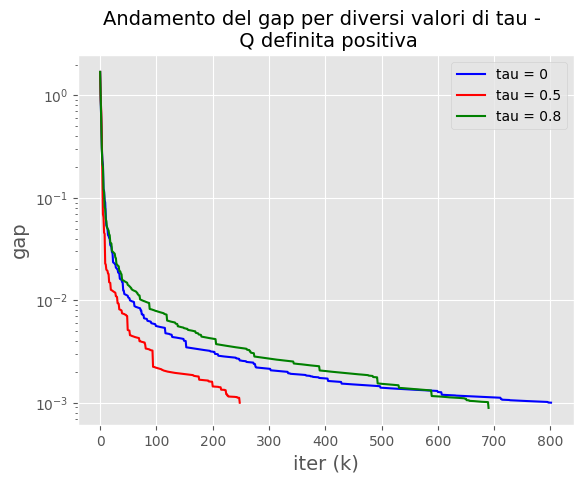

In [107]:
plt.style.use('ggplot')
plt.plot(list(range(k+1)), dual_gap, label = 'tau = 0', color = 'blue')
plt.plot(list(range(k_2+1)), dual_gap_2, label='tau = 0.5', color = 'red')
plt.plot(list(range(k_3+1)), dual_gap_3, label='tau = 0.8', color = 'green')
plt.ylabel ('gap',  fontsize = 14)
plt.xlabel('iter (k)',  fontsize = 14)
plt.yscale('log')
plt.title('Andamento del gap per diversi valori di tau - \n Q definita positiva', fontsize = 14)
plt.legend()
plt.show()

In [48]:
## PROVA DI FW AWAY STEP
 
k_granularity = 2
func = lambda x: np.dot(x, np.dot(Q, x))+np.dot(q,x)
nome_file_dmx = '1000/netgen-1000-1-1-b-b-s.dmx'
n, numero_archi, u, b, q, _, from_ , to = leggi_file_dimacs(nome_file_dmx)
Q = genera_Q(10, u, q, numero_archi, 0.3)
x_0 = u/2
#Q = np.load('Q.npy')   
f_tol = 1e-9
time_tol = np.inf
epsilon = 1e-4
tau = 0
max_iter = 2000
f_values, k, tempo_tot, tempi_per_it, x, dual_gap, tempo_per_it_MCF, elapsed_time = AFW(epsilon, max_iter, Q, q, numero_archi,func, k_granularity, x, visualize_res=True)

iter: 1 iter, fval = 120122.99231690136, fbest = 1.20122992e+05, gap = 1.3440e+00
iter: 2 iter, fval = 103555.0138356378, fbest = 1.03555014e+05, gap = 8.7551e-01
iter: 3 iter, fval = 95962.92807215873, fbest = 9.59629281e+04, gap = 6.2791e-01
iter: 4 iter, fval = 91909.98324920611, fbest = 9.19099832e+04, gap = 4.8860e-01
iter: 5 iter, fval = 90176.99868133978, fbest = 9.01769987e+04, gap = 3.6230e-01
iter: 6 iter, fval = 89359.73085065896, fbest = 8.93597309e+04, gap = 3.4222e-01
iter: 7 iter, fval = 88151.51354379172, fbest = 8.81515135e+04, gap = 2.8900e-01
iter: 8 iter, fval = 87483.4025579752, fbest = 8.74834026e+04, gap = 2.1680e-01
iter: 9 iter, fval = 87184.06586230209, fbest = 8.71840659e+04, gap = 2.1082e-01
iter: 10 iter, fval = 86594.56669348167, fbest = 8.65945667e+04, gap = 2.0811e-01
iter: 11 iter, fval = 86386.40032095354, fbest = 8.63864003e+04, gap = 1.8545e-01
iter: 12 iter, fval = 86027.38938155388, fbest = 8.60273894e+04, gap = 1.7775e-01
iter: 13 iter, fval = 855

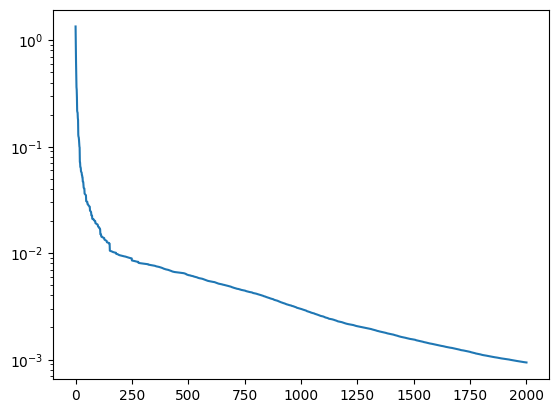

In [49]:
plt.plot(list(range(k+1)), dual_gap)
plt.yscale('log')

### 3. Funzioni per PLOT


In [13]:
# queste due funzioni plottano il FW (dual) gap e il primal gap 

def plot_dual_gap(gap_fw, gap_afw, axes):
    
    gap_fw = np.abs(gap_fw)
    gap_afw = np.abs(gap_afw)
    iterazioni_fw = list(range(1, len(gap_fw) + 1))
    iterazioni_afw = list(range(1, len(gap_afw) + 1))

    plt.style.use('ggplot')
    # plt.figure(figsize=(8, 6))
    axes[0].plot(iterazioni_fw, gap_fw, color = 'lightseagreen', label = 'FW')
    axes[0].plot(iterazioni_afw, gap_afw, color = 'darkred', label = 'AFW')
    axes[0].set_xlabel('Iterazioni (k)', fontsize= 10)
    axes[0].set_yscale('log')
    axes[0].set_ylabel(r'dual gap = $|<grad(f), d>|$', fontsize=10)
    
    axes[0].set_title('Andamento del Dual Gap (aka FW Gap) in funzione di k', fontsize=11)
    axes[0].legend(fontsize='small', loc='upper right')
    plt.grid(True)

    # plt.show()


def plot_primal_gap(f_values_fw, xstar_fw, found_optimal_fw, f_values_afw, xstar_afw, found_optimal_afw, axes):   
    # f(x) - f(x*)

    # check iniziale:  
    # se l'algoritmo ha trovato x ottima (ie il criterio di stop verificato è quello sul gap, non su max iter)
    # allora ha senso calcolare f(x*)
    if found_optimal_fw and found_optimal_afw:

        xstar_fw = np.array(xstar_fw)
        xstar_afw = np.array(xstar_afw)
        fxstar_fw = xstar_fw.T @ Q @ xstar_fw + q @ xstar_fw
        fxstar_afw = xstar_afw.T @ Q @ xstar_afw + q @ xstar_afw
        gap_fw = np.abs(f_values_fw - fxstar_fw)
        gap_afw = np.abs(f_values_afw - fxstar_afw)
        iterazioni_fw = list(range(1, len(f_values_fw) + 1))
        iterazioni_afw = list(range(1, len(f_values_afw) + 1))
        
        plt.style.use('ggplot')
        #plt.figure(figsize=(8, 6))
        axes[1].plot(iterazioni_fw, gap_fw, color = 'lightseagreen', label = 'FW')
        axes[1].plot(iterazioni_afw, gap_afw, color = 'darkred', label = 'AFW')
        axes[1].set_xlabel('Iterazioni (k)', fontsize=10)
        axes[1].set_yscale('log')
        axes[1].set_ylabel(r'primal gap = $|f(x) - f(x*)|$', fontdict={'style': 'italic', 'fontsize':10})
        
        axes[1].set_title('Andamento del Primal Gap in funzione di k', fontsize=11)
        axes[1].legend(fontsize='small', loc='upper right')
        
        plt.grid(True)

        # plt.show()
        
    else: 
        ('primal gap non disponibile')

In [ ]:
def plot_dual_gap_bis(gap_fw, gap_afw, p, alpha): # senza axes 
    
    gap_fw = np.abs(gap_fw)
    gap_afw = np.abs(gap_afw)
    iterazioni_fw = list(range(1, len(gap_fw) + 1))
    iterazioni_afw = list(range(1, len(gap_afw) + 1))

    plt.style.use('ggplot')
    plt.figure(figsize=(8, 6))
    plt.plot(iterazioni_fw, gap_fw, color = 'lightseagreen', label = 'FW')
    plt.plot(iterazioni_afw, gap_afw, color = 'darkred', label = 'AFW')
    # axes[0].axhline(y = 0.0001, color='red', linestyle='--', label='Valore stop epsilon')
    plt.xlabel('Iterazioni (k)', fontsize= 12)
    plt.yscale('log')
    plt.ylabel(r'dual gap = $|<grad(f), d>|$', fontsize=12)
    # plt.xticks(iterazioni_fw)
    plt.title('Andamento del FW Gap in funzione di k - p={}, alpha={}'.format(p, alpha), fontsize=14)
    plt.legend(fontsize='small', loc='upper right')
    plt.grid(True)

    plt.show()


In [15]:
# l'obiettivo di questa funzione è mostrare che effettivamente il FW gap (dual gap) costituisce un upper bound al primal gap


def plot_dual_and_primal_gap(f_values, dual_gap, xstar):
    dual_gap = np.abs(dual_gap)
    iterazioni = list(range(1, len(dual_gap) + 1))
    
    plt.style.use('ggplot')
    plt.figure(figsize=(8, 6))
    
    plt.plot(iterazioni, dual_gap, color='lightseagreen', label='Dual Gap (aka FW Gap)')
    
    xstar = np.array(xstar)
    fxstar = xstar.T @ Q @ xstar + q @ xstar
    primal_gap = np.abs(f_values - fxstar)
    plt.plot(iterazioni, primal_gap, color='dodgerblue', label='Primal Gap')
    
    plt.xlabel('Iterazioni (k)')
    plt.ylabel('Gap', fontdict={'style': 'italic'})
    
    plt.title('Andamento del Dual Gap e del Primal Gap in funzione di k - 1000 nodi', fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.show()


In [134]:
# questa funzione plotta un grafico di convergenza: 
# viene mostrato l'andamento della convergenza teorica e reale per FW tradizionale
# conv teorica  :  f(x)-f(x^*) <=  2LD^2 / (k+3)
def plot_convergenza(f_values, k_tot, Q, nome_file_dmx):
    
    _, _, u, _, _, _, _ , _ = leggi_file_dimacs(nome_file_dmx)
    Q_diag = np.diag(Q)

    # l'autovalore massimo di Q è la costante di convergenza L 
    L = np.max(Q_diag)
    # il diametro dello spazio D è la norma del vettore u 
    D = np.linalg.norm(u) 

    k_values = []  # valori di k (iterazione)
    convergence_values = []  # valori di convergenza teorica

    # simulo i dati teorici (convergenza teorica)
    for k in range(1, k_tot + 1):
        k_values.append(k)
        convergence_values.append((2 * L * D**2) / (k + 3)) # formula converg teorica
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, convergence_values, label="Convergenza Teorica", linestyle='--', linewidth = 3)
    plt.plot(k_values, f_values, label="Convergenza Effettiva" , linestyle='-', linewidth = 3)
    # plt.yscale("log") 
    #plt.ylim(1e4, 1e9)
    plt.xlabel("Iterazione (k)", fontsize = 17)
    plt.ylabel(r'Valore di convergenza = $|f(x) - f(x*)|$', fontsize = 17)
    
    plt.legend()
    plt.title("Convergenza teorica vs effettiva", fontsize = 23)
    plt.grid(True)

    plt.show()

    return

### 4. Esperimenti

In [139]:
folder_path = r'C:\Users\39327\OneDrive\Documenti\unipi\optimization\1000' # path assoluto della cartella 1000
esperimenti = []
file_names = os.listdir(folder_path)

for file_name in file_names:
    if file_name.endswith('.dmx'):
        file_path = os.path.join(folder_path, file_name)
        relative_path = os.path.relpath(file_path, os.getcwd())
        esperimenti.append(relative_path)

#### Plot preliminari

Iteration:    1   Step size: 0.99999404   Valore di f in x_k: 44293.721362   Dual gap: 1063722979.19 
Iteration:    2   Step size: 0.01167711   Valore di f in x_k: 44015.170277   Dual gap:   47708.90 
Iteration:    3   Step size: 0.00953445   Valore di f in x_k: 43802.486577   Dual gap:   44613.73 
Iteration:    4   Step size: 0.01299105   Valore di f in x_k: 43525.092610   Dual gap:   42705.41 
Iteration:    5   Step size: 0.02153495   Valore di f in x_k: 43087.987402   Dual gap:   40594.95 
Iteration:    6   Step size: 0.03039584   Valore di f in x_k: 42503.512066   Dual gap:   38457.59 
Iteration:    7   Step size: 0.00673857   Valore di f in x_k: 42380.268676   Dual gap:   36578.52 
Iteration:    8   Step size: 0.00896514   Valore di f in x_k: 42220.678506   Dual gap:   35602.37 
Iteration:    9   Step size: 0.02886832   Valore di f in x_k: 41740.245018   Dual gap:   33284.47 
Iteration:   10   Step size: 0.00853501   Valore di f in x_k: 41608.081098   Dual gap:   30969.85 
Iterati

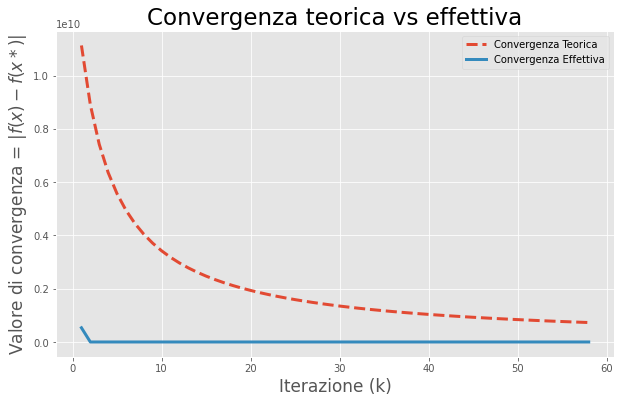

In [137]:
nome_file_dmx = '1000/netgen-1000-1-1-b-b-s.dmx'
_, numero_archi, u, _, q, _, _, _ = leggi_file_dimacs(nome_file_dmx)
x_0 = u/2
Q = genera_Q(1000, u, q, numero_archi, 0.2)

x, function_value, elapsed_time, primal_gap, k, tempi_per_it, tempo_per_it_MCF = FW_trad_modificato(b,n,from_,to,f_tol, time_tol, nome_file_dmx, epsilon, Q, q, u, numero_archi,x_0, step_size_ottimo=True, visualize_res=True)
plot_convergenza(function_value, k+1, Q, nome_file_dmx)

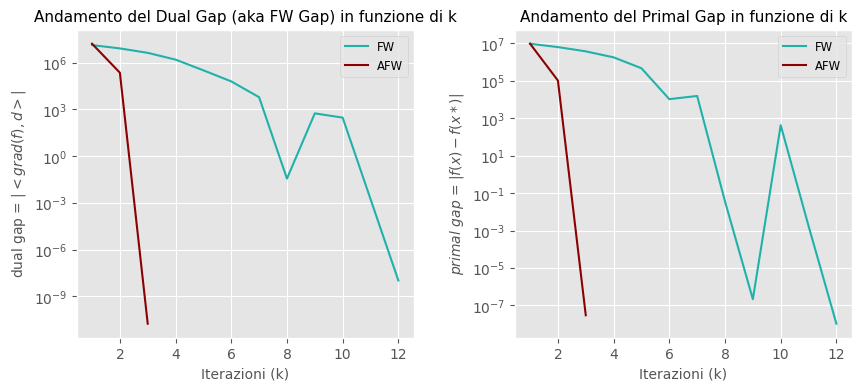

In [33]:
for nome_file_dmx in esperimenti[:10]:  # uso i primi file dmx
    
    _, numero_archi, u, _, q, _, _ , _ = leggi_file_dimacs(nome_file_dmx)
    Q = genera_Q(10, u, q, numero_archi, 0.3)
    func = lambda x: np.dot(x, np.dot(Q, x))+np.dot(q,x)

    np.random.seed(42)
    x_0 = []
    for u_i in u:
        x_i = random.randint(0, u_i)
        x_0.append(x_i)
    
    gap, valori_f, k_totale, tempo_totale, tempi_per_it, x, sol_ottima, found_optimal = algoritmo_tradizionale(nome_file_dmx, epsilon = 0.001, max_iter = 1000, Q = Q, q = q, u = u, numero_archi = numero_archi, tau = 0.01, step_size_ottimo = True, x_0 = x_0, visualize_res = False)
    gap_afw, f_values_afw, k_afw, tempo_tot_afw, tempi_per_it_afw, x_afw, found_optimal_afw = AFW(nome_file_dmx, epsilon = 0.001, max_iter = 1000, Q = Q, q = q, numero_archi = numero_archi, func=func, k_granularity=1, x_0 = x_0, visualize_res = False)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    plt.subplots_adjust(wspace=0.3)
    plot_primal_gap(valori_f, x, found_optimal,f_values_afw, x_afw, found_optimal_afw, axes)
    plot_dual_gap(gap, gap_afw, axes)

    # file_name_png = nome_file_dmx + '.png'
    # plt.savefig(file_name_png, dpi=300, bbox_inches='tight')

    plt.show()

#### Effetto della Trust Region Stabilization

In [24]:
taus = [0, 0.0001, 0.001, 0.01, 0.1, 0.5] # tau da provare

repetitions = 5
# repetitions = 1 

data = {'Tau': taus, 'Media_Iterazioni': [], 'Media_Tempi': [], 'Numero di volte in cui è stato trovato ottimo': []}

for tau in taus:

    iterazioni_per_tau = []
    tempi_per_tau = []
    ottimo = 0

    for nome_file_dmx in esperimenti[:100]:  
        
        # raccolgo risultati per file specifico
        iterazioni_per_file = []
        tempi_per_file = []
        ottimo_per_file = 0

        for _ in range(repetitions): 
            _, numero_archi, u, _, q, _, _, _ = leggi_file_dimacs(nome_file_dmx)
            Q = genera_Q(10, u, q, numero_archi, 0.3)
            func = lambda x: np.dot(x, np.dot(Q, x)) + np.dot(q, x)

            np.random.seed(42)
            x_0 = [random.randint(0, u_i) for u_i in u]

            try:
                gap, valori_f, k_totale, tempo_totale, tempi_per_it, x, sol_ottima, found_optimal = algoritmo_tradizionale(nome_file_dmx, epsilon=0.0001, max_iter=1000, Q=Q, q=q, u=u, numero_archi=numero_archi, tau=tau, step_size_ottimo=True, x_0=x_0, visualize_res=False)
            except ProblemUnfeasibleError as e: 
                break

            iterazioni_per_file.append(k_totale)
            tempi_per_file.append(tempo_totale)
            if found_optimal:
                ottimo_per_file += 1

        # media dei risultati per file
        try:
            media_iterazioni_file = sum(iterazioni_per_file) / len(iterazioni_per_file)
            media_tempi_file = sum(tempi_per_file) / len(tempi_per_file)
        except:
            media_iterazioni_file = 0
            media_tempi_file = 0
        
        iterazioni_per_tau.append(media_iterazioni_file)
        tempi_per_tau.append(media_tempi_file)
        ottimo += ottimo_per_file

    try:
        media_iterazioni = sum(iterazioni_per_tau) / len(iterazioni_per_tau)
        media_tempi = sum(tempi_per_tau) / len(tempi_per_tau)
    except: 
        media_iterazioni = 0
        media_tempi = 0

    data['Media_Iterazioni'].append(media_iterazioni)
    data['Media_Tempi'].append(media_tempi)
    data['Numero di volte in cui è stato trovato ottimo'].append(ottimo)

df = pd.DataFrame(data)
# df.to_csv('tabella_effetto_trust_region', index=False)

C:\Users\Valeria\AppData\Local\Temp\ipykernel_6676\3491097637.py:11: RuntimeWarning: overflow encountered in matmul
  return x_alpha.T @ Q @ x_alpha + q @ x_alpha
c:\Users\Valeria\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_optimize.py:2233: RuntimeWarning: invalid value encountered in double_scalars
  r = (xf - nfc) * (fx - ffulc)
c:\Users\Valeria\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_optimize.py:2234: RuntimeWarning: invalid value encountered in double_scalars
  q = (xf - fulc) * (fx - fnfc)


#### Effetto di p (percentuale di autovalori a 0 in Q) sul numero di iterazioni/tempi

In [16]:
nome_file_dmx = '1000/netgen-1000-1-1-b-b-s.dmx'

_, numero_archi, u, _, q, _, _, _ = leggi_file_dimacs(nome_file_dmx)
x_0 = [random.randint(0, u_i) for u_i in u]

repetitions = 10
iterazioni = []
tempi = []
ottimo = []

for p in np.linspace(0, 1, 11):

    iterazioni_per_p = []
    tempi_per_p = []
    ottimo_per_p = 0

    for _ in range(repetitions):
        Q = genera_Q(10, u, q, numero_archi, p)
        try:
            gap, valori_f, k_totale, tempo_totale, tempi_per_it, x, sol_ottima, found_optimal = algoritmo_tradizionale(
                nome_file_dmx, epsilon=0.0001, max_iter=1000, Q=Q, q=q, u=u, numero_archi=numero_archi, tau=0.01, step_size_ottimo=True, x_0=x_0, visualize_res=False)
        except ProblemUnfeasibleError as e:
            break

        iterazioni_per_p.append(k_totale)
        tempi_per_p.append(tempo_totale)

        if found_optimal:
            ottimo_per_p += 1

    try:
        media_iterazioni_p = sum(iterazioni_per_p) / len(iterazioni_per_p)
        media_tempi_p = sum(tempi_per_p) / len(tempi_per_p)
    except ZeroDivisionError:
        media_iterazioni_p = 0
        media_tempi_p = 0

    iterazioni.append(media_iterazioni_p)
    tempi.append(media_tempi_p)
    ottimo.append(ottimo_per_p)


C:\Users\Valeria\AppData\Local\Temp\ipykernel_14564\3491097637.py:11: RuntimeWarning: overflow encountered in matmul
  return x_alpha.T @ Q @ x_alpha + q @ x_alpha
c:\Users\Valeria\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_optimize.py:2233: RuntimeWarning: invalid value encountered in double_scalars
  r = (xf - nfc) * (fx - ffulc)
c:\Users\Valeria\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_optimize.py:2234: RuntimeWarning: invalid value encountered in double_scalars
  q = (xf - fulc) * (fx - fnfc)


In [17]:
# stesso esperimento - per AFW 

nome_file_dmx = '1000/netgen-1000-1-1-b-b-s.dmx'
_, numero_archi, u, _, q, _, _, _ = leggi_file_dimacs(nome_file_dmx)
x_0 = [random.randint(0, u_i) for u_i in u]
func = lambda x: np.dot(x, np.dot(Q, x)) + np.dot(q, x)

repetitions = 10
iterazioni_afw = []
tempi_afw = []
ottimo_afw = []

for p in np.linspace(0, 1, 11):

    iterazioni_per_p = []
    tempi_per_p = []
    ottimo_per_p = 0

    for _ in range(repetitions):
        Q = genera_Q(10, u, q, numero_archi, p)
        try:
            gap_afw, f_values_afw, k_afw, tempo_tot_afw, tempi_per_it_afw, x_afw, found_optimal_afw = AFW(nome_file_dmx, epsilon = 0.0001, max_iter = 1000, Q = Q, 
                                                                                                          q = q, numero_archi = numero_archi, func=func, k_granularity=1, x_0 = x_0, visualize_res = False)
        except ProblemUnfeasibleError as e:
            break

        iterazioni_per_p.append(k_afw)
        tempi_per_p.append(tempo_tot_afw)

        if found_optimal:
            ottimo_per_p += 1

    try:
        media_iterazioni_p = sum(iterazioni_per_p) / len(iterazioni_per_p)
        media_tempi_p = sum(tempi_per_p) / len(tempi_per_p)
    except ZeroDivisionError:
        media_iterazioni_p = 0
        media_tempi_p = 0

    iterazioni_afw.append(media_iterazioni_p)
    tempi_afw.append(media_tempi_p)
    ottimo_afw.append(ottimo_per_p)

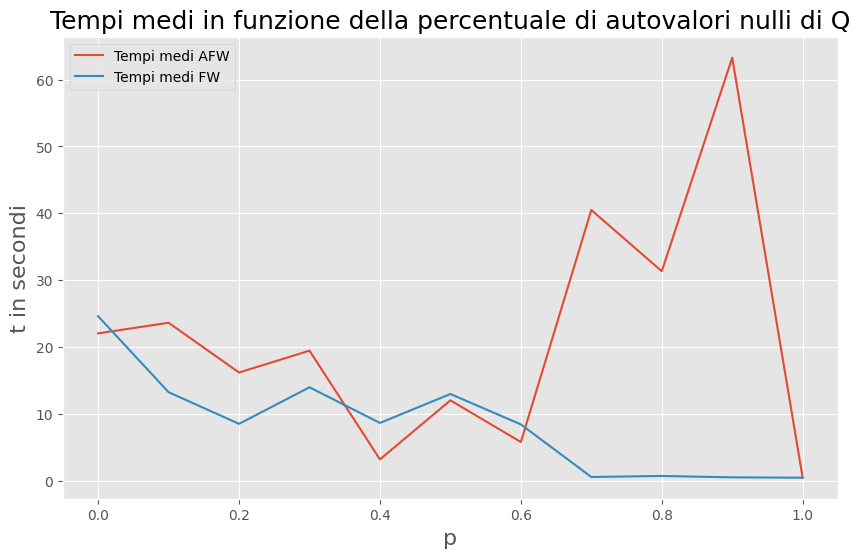

In [34]:
# PLOT 
plt.style.use('ggplot') 
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, 1, 11), tempi_afw, label='Tempi medi AFW')
plt.plot(np.linspace(0, 1, 11), tempi, label='Tempi medi FW')

plt.xlabel('p', fontsize = 16)
plt.ylabel('t in secondi', fontsize = 16)
plt.legend()
plt.title('Tempi medi in funzione della percentuale di autovalori nulli di Q', fontsize = 18)
#plt.ylim(-1, 40)   
plt.show()

#### Confronto FW e AFW su dual gap


In [40]:
# inizializzazione di x_0
x_0 = [random.randint(0, u_i) for u_i in u]

# np.save('x0.npy', x_0) # per fare gli esperimenti con  stessa x0
# x_0 = np.load('x0.npy') 

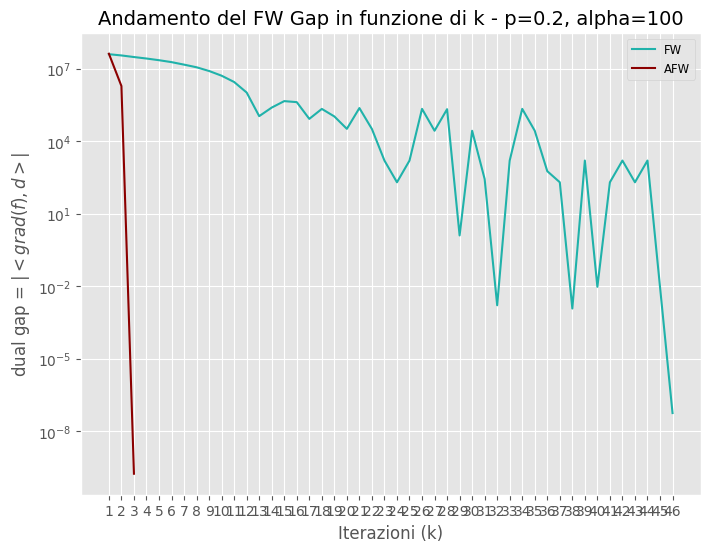

In [43]:
nome_file_dmx = '1000/netgen-1000-1-1-a-b-s.dmx'
_, numero_archi, u, _, q, _, _ , _ = leggi_file_dimacs(nome_file_dmx)
p = 0.2
alpha = 100

# Q = genera_Q(alpha, u, q, numero_archi, p)
Q = genera_Q(alpha, u, q, numero_archi, p)
# Q = genera_Q(alpha, u, q, numero_archi, p)
func = lambda x: np.dot(x, np.dot(Q, x))+np.dot(q,x)


gap, valori_f, k_totale, tempo_totale, tempi_per_it, x, sol_ottima, found_optimal = algoritmo_tradizionale(nome_file_dmx, epsilon = 0.0001, max_iter = 1000, Q = Q, q = q, u = u, numero_archi = numero_archi, tau = 0.01, step_size_ottimo = True, x_0 = x_0, visualize_res = False)
gap_afw, f_values_afw, k_afw, tempo_tot_afw, tempi_per_it_afw, x_afw, found_optimal_afw = AFW(nome_file_dmx, epsilon = 0.0001, max_iter = 1000, Q = Q, q = q, numero_archi = numero_archi, func=func, k_granularity=1, x_0 = x_0, visualize_res = False)

plot_dual_gap_bis(gap, gap_afw, p=p, alpha=alpha)